# Raster Download and Terrain Analysis with WCS

This notebook demonstrates a workflow for working with raster data obtained through a Web Coverage Service (WCS). Specifically, it involves the following steps:

1. **Connecting and downloading raster data**: Accessing a WCS to download a raster dataset corresponding to a specific geographic extent defined by a GeoJSON file.
2. **Generating raster derivatives**: Creating various derived products from the downloaded raster, including:
    * Slope map
    * Aspect map
    * Hillshade map

These derived products are useful for topographic analysis, terrain modeling, and geospatial studies in applications such as environmental, geological, and urban research. The notebook is designed to automate this workflow and streamline the analysis process.

## 1. Read in the geojson file and WCS connection

First of all, we'll import all the libraries needed and read the geojson which stores the extension of our study area.

In [1]:
# Import libraries
from owslib.wcs import WebCoverageService
from osgeo import gdal
import os
import parameters
import geopandas as gpd
import glob
import contextily as ctx
import matplotlib.pyplot as plt
import rasterio 

In [2]:
# Read the file as a geodataframe
polygon = gpd.read_file(parameters.input_file)

In [3]:
# Bounding boxes of the polygon
minx, miny, maxx, maxy = polygon.total_bounds

bbox = (minx, miny, maxx, maxy)

In the following visualization, the polygon representing the study area will be displayed over an OpenStreetMap (OSM) basemap. This allows for a clear understanding of the extent and location of the area of interest. The polygon is kept in its original CRS (EPSG:25830), and the basemap has been adjusted accordingly to ensure proper alignment. The axis labels have been removed to avoid clutter and improve readability.

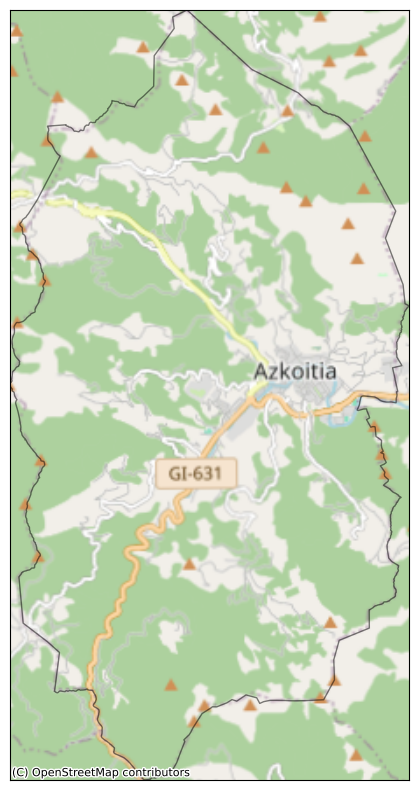

In [4]:
# Figure
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygon
polygon.plot(ax=ax, alpha=0.5, edgecolor="black", facecolor="none")

# OSM mapabase with EPSG:25830
ctx.add_basemap(ax, crs=polygon.crs, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

# Plot limits
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Axis labels
ax.set_xticks([])
ax.set_yticks([])

plt.show()

After reading the polygon that defines the study area, the next step is to connect to the WCS (Web Coverage Service) to retrieve spatial data for analysis. The WCS request will be configured to match the spatial resolution required for the project, ensuring that the retrieved data aligns with the needs of the study. This step is critical for obtaining geospatial data that accurately represents the extent and resolution of the study area.

In [5]:
# WCS connection
wcs = WebCoverageService(parameters.wcs_url, version='1.0.0')

# Spatial Resolution
resolution_x = 5  # 5 meters
resolution_y = 5  # 5 meters

In [6]:
# Identifier an title for each layer in the service
for layer_id, layer_info in wcs.contents.items():
    print(f"Identifier: {layer_id}, Title: {layer_info.title}")

Identifier: 1, Title: MDS_LIDAR_1M_EGUNERATUENA_MAS_ACTUALIZADA
Identifier: 2, Title: MDT_LIDAR_1M_EGUNERATUENA_MAS_ACTUALIZADA
Identifier: 3, Title: MDT_LIDAR_5M_EGUNERATUENA_MAS_ACTUALIZADA
Identifier: 4, Title: MDT_LIDAR_25M_EGUNERATUENA_MAS_ACTUALIZADA
Identifier: 5, Title: ORIENTACIONES_LIDAR_25M_EGUNERATUENA_MAS_ACTUALIZADA
Identifier: 6, Title: PENDIENTES_LIDAR_25M_EGUNERATUENA_MAS_ACTUALIZADA
Identifier: 7, Title: MDS_LIDAR_2008_1M
Identifier: 8, Title: MDT_LIDAR_2008_1M
Identifier: 9, Title: MDT_LIDAR_2008_5M
Identifier: 10, Title: MDT_LIDAR_2008_25M
Identifier: 11, Title: MDS_LIDAR_2012_1M
Identifier: 12, Title: MDT_LIDAR_2012_1M
Identifier: 13, Title: MDT_LIDAR_2012_5M
Identifier: 14, Title: MDT_LIDAR_2012_25M
Identifier: 15, Title: MDT_LIDAR_2013_1M
Identifier: 16, Title: MDT_LIDAR_2013_5M
Identifier: 17, Title: MDT_LIDAR_2013_25M
Identifier: 18, Title: MDT_LIDAR_2016_1M
Identifier: 19, Title: MDT_LIDAR_2016_5M
Identifier: 20, Title: MDT_LIDAR_2016_25M
Identifier: 21, Title

We will select the third layer, which contains the Digital Terrain model (DTM) with a 5 meter resolution for the entire Basque Country. It is worth mentioning that this raster was obtained through an aerial survey equipped with LiDAR.

In [7]:
# Select the layer with the local coordinate system and the resolution mentioned above
response = wcs.getCoverage(
    identifier='3',
    bbox=bbox,
    crs='EPSG:25830',
    format='GeoTIFF',
    resx=resolution_x,
    resy=resolution_y,
    timeout=180
)

To conclude the first step, the DTM for the study area will be downloaded in GeoTIFF format. This high-resolution DTM will serve as a foundational dataset for subsequent analyses, providing detailed elevation information within the defined polygon extent.

In [8]:
# Raster path
mdt_path = os.path.join(parameters.output_dir, 'clipped_mdt.tif')

# Create the folder 
if not os.path.exists(parameters.output_dir):
    os.makedirs(parameters.output_dir)

# Store as a GeoTIFF
with open(mdt_path, 'wb') as f:
    f.write(response.read())

## 2. Slope, Aspect and Hillsahed maps

In the next step, the ```gdal.DEMProcessing``` function will be used to derive additional terrain datasets from the previously downloaded 5-meter resolution Digital Terrain Model (DTM). Before generating these maps, directories will be created to store the resulting files, ensuring an organized workflow.

The following maps will be generated:

* **Slope Map**: Highlights the steepness of the terrain.
* **Aspect Map**: Shows the orientation of the slopes, indicating the direction they face.
* **Hillshade Map**: Creates a shaded relief visualization for better understanding of terrain features.

These outputs will provide essential insights into the topography of the study area, supporting more detailed geospatial analyses. In addition, by visualizing these maps directly in the notebook, we gain immediate insights into the topographic characteristics of the study area, facilitating a deeper understanding of the terrain and its spatial properties.

In [9]:
# Define raster directories
slope_output_path = os.path.join(parameters.output_dir, 'slope', 'slope.tif')
aspect_output_path = os.path.join(parameters.output_dir, 'aspect', 'aspect.tif')
hillshade_output_path = os.path.join(parameters.output_dir, 'hillshade', 'hillshade.tif')

# Create folders
os.makedirs(os.path.dirname(slope_output_path), exist_ok=True)
os.makedirs(os.path.dirname(aspect_output_path), exist_ok=True)
os.makedirs(os.path.dirname(hillshade_output_path), exist_ok=True)

### 2.1. Slope

In [10]:
# Read DTM using gdal
dtm_name = os.path.join(parameters.output_dir, 'clipped_mdt.tif')
dtm = gdal.Open(dtm_name)

c:\Users\User\miniconda3\envs\gis\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [11]:
# Slope
slope = gdal.DEMProcessing(slope_output_path, dtm, 'slope', computeEdges=True, zFactor=1)

In [12]:
# Run the function twice
slope = gdal.DEMProcessing(slope_output_path, dtm, 'slope', computeEdges=True, zFactor=1)

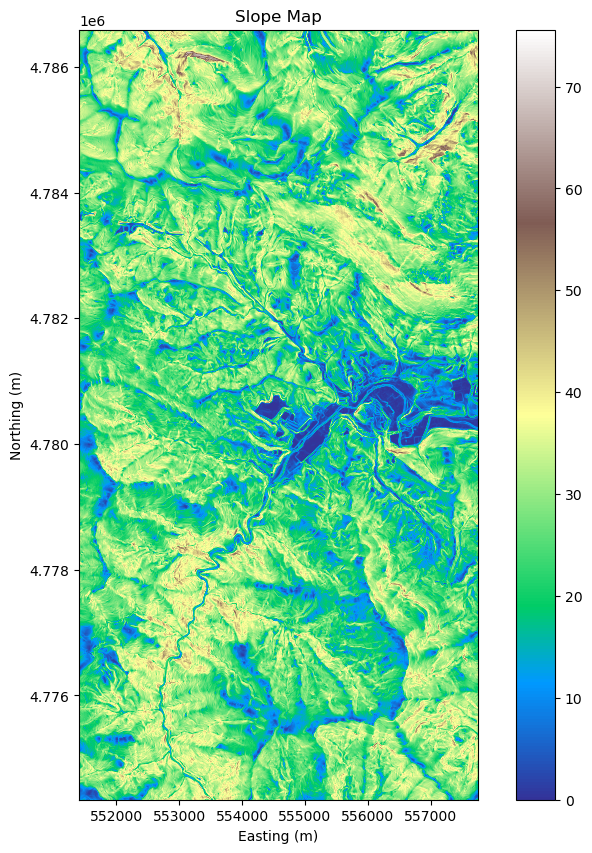

In [13]:
# Plot the map
with rasterio.open(slope_output_path) as src:
    # Read the first band (slope values)
    slope_data = src.read(1)  
    # Store raster metadata
    slope_meta = src.meta  

# Configure the visualization
plt.figure(figsize=(10, 10))
plt.title("Slope Map")
plt.imshow(
    slope_data, 
    cmap='terrain', 
    extent=(
        slope_meta['transform'][2],  # Min X
        slope_meta['transform'][2] + slope_meta['transform'][0] * src.width,  # Max X
        slope_meta['transform'][5] + slope_meta['transform'][4] * src.height,  # Min Y
        slope_meta['transform'][5]  # Max Y
    )
) 

# Adding a color bar
plt.colorbar()
# Labels
plt.xlabel("Easting (m)") 
plt.ylabel("Northing (m)")
plt.show()

### 2.2. Aspect

In [14]:
# Aspect
aspect = gdal.DEMProcessing(aspect_output_path, dtm, 'aspect', computeEdges=True, zFactor=1)

In [15]:
# Run the function twice
aspect = gdal.DEMProcessing(aspect_output_path, dtm, 'aspect', computeEdges=True, zFactor=1)

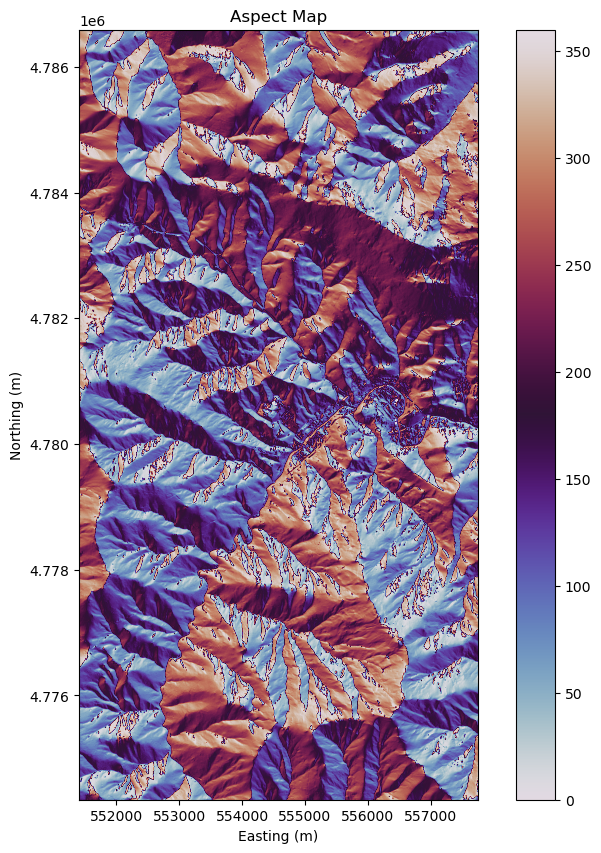

In [16]:
# Plot the aspect map
with rasterio.open(aspect_output_path) as src:
    # Read the first band (aspect values)
    aspect_data = src.read(1)  
    # Store raster metadata
    aspect_meta = src.meta  

# Configure the visualization
plt.figure(figsize=(10, 10))
plt.title("Aspect Map")
plt.imshow(
    aspect_data, 
    cmap='twilight',
    extent=(
        aspect_meta['transform'][2],  # Min X
        aspect_meta['transform'][2] + aspect_meta['transform'][0] * src.width,  # Max X 
        aspect_meta['transform'][5] + aspect_meta['transform'][4] * src.height,  # Min Y
        aspect_meta['transform'][5]  # Max Y
    ),
    vmin = 0,
    vmax = 360
) 

# Adding a color bar
plt.colorbar()
# Labels
plt.xlabel("Easting (m)") 
plt.ylabel("Northing (m)")
plt.show()

### 2.3. Hillshade

In [17]:
# Hillshade
hillshade = gdal.DEMProcessing(hillshade_output_path, dtm, 'hillshade', computeEdges=True, zFactor=1, altitude=45, scale=1)

In [18]:
# Run the function twice
hillshade = gdal.DEMProcessing(hillshade_output_path, dtm, 'hillshade', computeEdges=True, zFactor=1, altitude=45, scale=1)

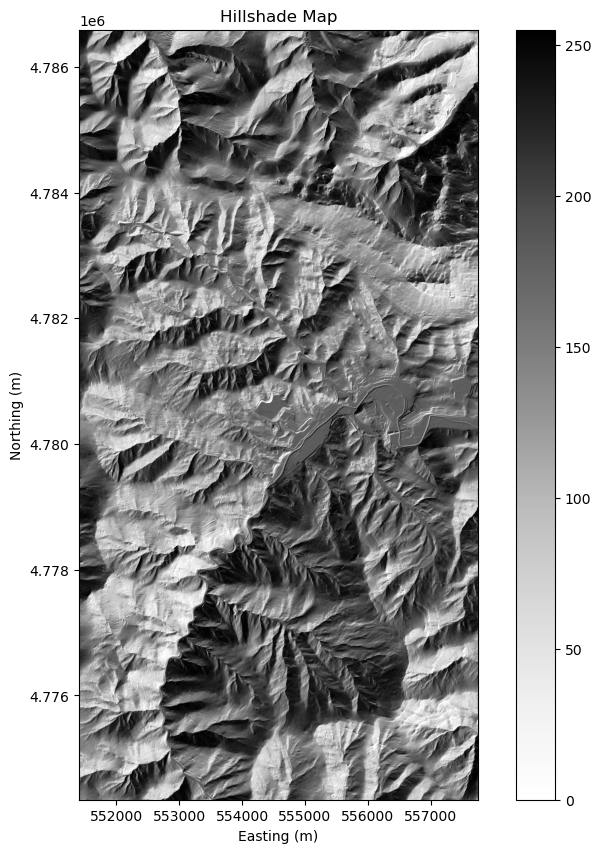

In [19]:
# Plot the hillshade map
with rasterio.open(hillshade_output_path) as src:
    # Read the first band (hillshade values)
    hillshade_data = src.read(1)  
    # Store raster metadata
    hillshade_meta = src.meta  

# Configure the visualization
plt.figure(figsize=(10, 10))
plt.title("Hillshade Map")
plt.imshow(
    hillshade_data, 
    cmap='Greys', 
    extent=(
        hillshade_meta['transform'][2],  # Min X
        hillshade_meta['transform'][2] + hillshade_meta['transform'][0] * src.width,  # Max X 
        hillshade_meta['transform'][5] + hillshade_meta['transform'][4] * src.height,  # Min Y 
        hillshade_meta['transform'][5]  # Max Y
    ),
    vmin=0,  
    vmax=255
) 

# Adding a color bar
plt.colorbar()
# Labels
plt.xlabel("Easting (m)") 
plt.ylabel("Northing (m)")
plt.show()